# Setup

Set up DUSt3R as described in readme

3D visualization requires first installing [Blender](https://www.blender.org/). 

To install additional dependencies for the notebook:
```
python -m pip install blender-notebook blender-plots ipykernel ipywidgets ipympl
blender_notebook install --blender-exec=/home/linus/workspace/blender/blender-4.0.1-linux-x64/blender --kernel-name blender-dust3r
```

# Init

In [4]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import numpy as np
import os
np.set_printoptions(linewidth=1000)
np.set_printoptions(threshold=5000)

from matplotlib import pyplot as plt
%matplotlib widget

def pprint(array, precision=4):
    with np.printoptions(
        precision=precision,
        suppress=True,
    ):
        print(array)

def image_ids_to_pair_id(image_id1, image_id2):
    if image_id1 > image_id2:
        return 2147483647 * image_id2 + image_id1
    else:
        return 2147483647 * image_id1 + image_id2

def pair_id_to_image_ids(pair_id):
    image_id2 = pair_id % 2147483647
    image_id1 = (pair_id - image_id2) / 2147483647
    return int(image_id1), int(image_id2)

ydown2zup = np.array([
    [0, 0, 1],
    [-1, 0, 0],
    [0, -1, 0],
])
T_ydown2zup = np.array([
    [0, 0, 1, 0],
    [-1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, 0, 1],
])

def rotate_blender(points):
    return np.einsum('ij, ...j->...i', ydown2zup, points)

from PIL import Image
import ipywidgets as widgets

import torch
import dust3r
from dust3r.inference import inference
from dust3r.model import AsymmetricCroCo3DStereo
import dust3r.cloud_opt
import dust3r.utils.image
import dust3r.image_pairs

import blender_plots as bplt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=28), Output()), _dom_cl…

<function __main__.display_image(i)>

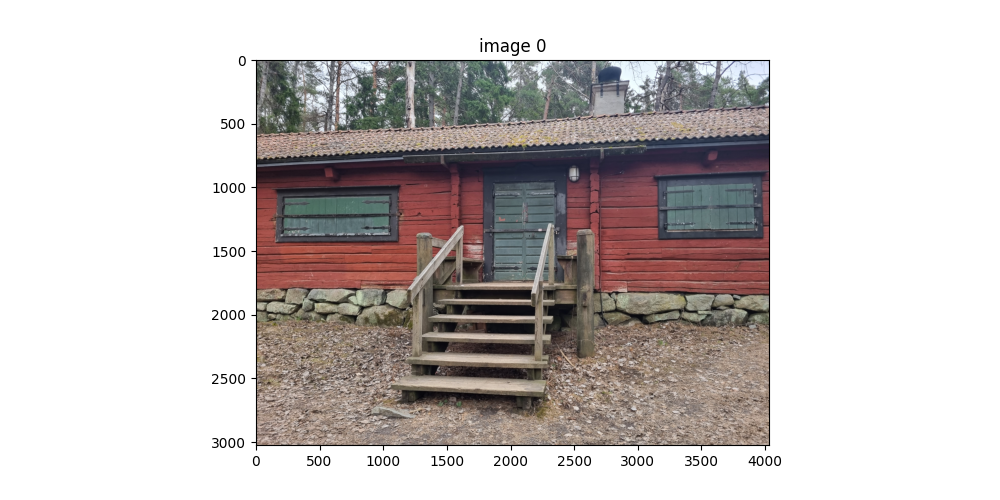

In [7]:
image_dir = Path('/home/linus/workspace/data/phone/house/images')
image_paths = sorted([str(image_dir / f) for f in os.listdir(image_dir) if f[-4:] == '.jpg'])
# image_dir = Path('/home/linus/workspace/data/navi_v1/dino_4/multiview_01_pixel_5/images/')
# image_paths = sorted([str(image_dir / f) for f in os.listdir(image_dir) if (f[-4:] == '.jpg') and ('downsampled' in f)])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
def display_image(i):
    image = Image.open(image_paths[i])
    ax.imshow(image)
    ax.set_title(f'image {i}')

widgets.interact(display_image, i=widgets.IntSlider(min=0, max=len(image_paths), continuous_update=False, value=0))

# DUSt3R

In [5]:
model = AsymmetricCroCo3DStereo.from_pretrained("checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth").to("cuda")

... loading model from checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='dpt', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>


In [8]:
images = dust3r.utils.image.load_images([
    image_paths[0],
    image_paths[24],
    image_paths[25],
], size=512)
image_pairs = dust3r.image_pairs.make_pairs(
    images,
    scene_graph="complete",
)

>> Loading a list of 3 images
 - adding /home/linus/workspace/data/phone/house/images/20240331_180805.jpg with resolution 4032x3024 --> 512x384
 - adding /home/linus/workspace/data/phone/house/images/20240331_181200.jpg with resolution 4032x3024 --> 512x384
 - adding /home/linus/workspace/data/phone/house/images/20240331_181205.jpg with resolution 4032x3024 --> 512x384
 (Found 3 images)


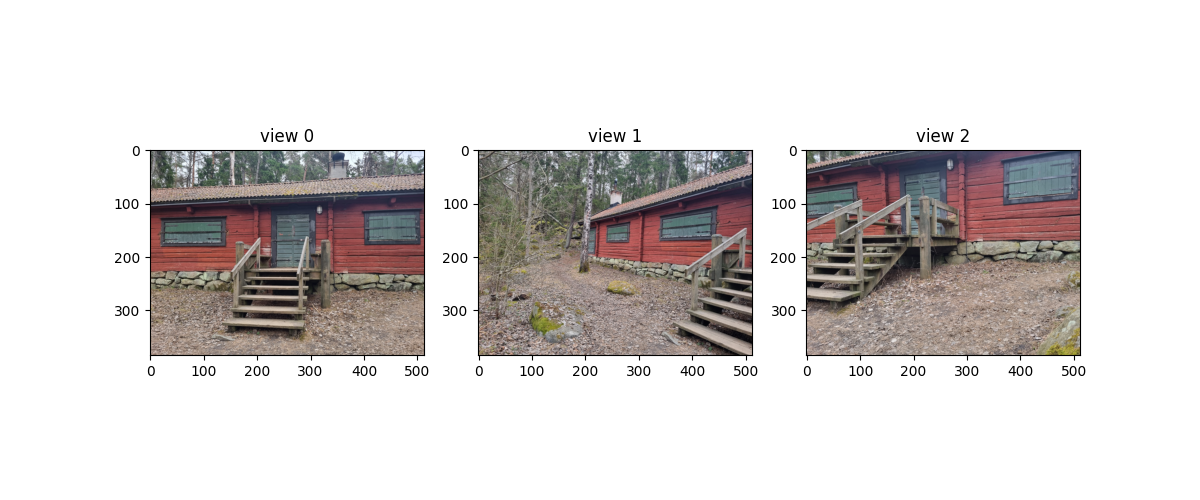

In [9]:
fig, ax = plt.subplots(1, len(images), figsize=(4 * len(images), 5))

for i in range(len(images)):
    ax[i].imshow(dust3r.utils.image.rgb(images[i]['img'][0]))
    ax[i].set_title(f'view {i}')

In [10]:
outputs = inference(
    pairs=image_pairs,
    model=model,
    device="cuda",
    batch_size=1,
    verbose=True,
)

>> Inference with model on 6 image pairs


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


## Raw 2-view point maps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'output confidence')

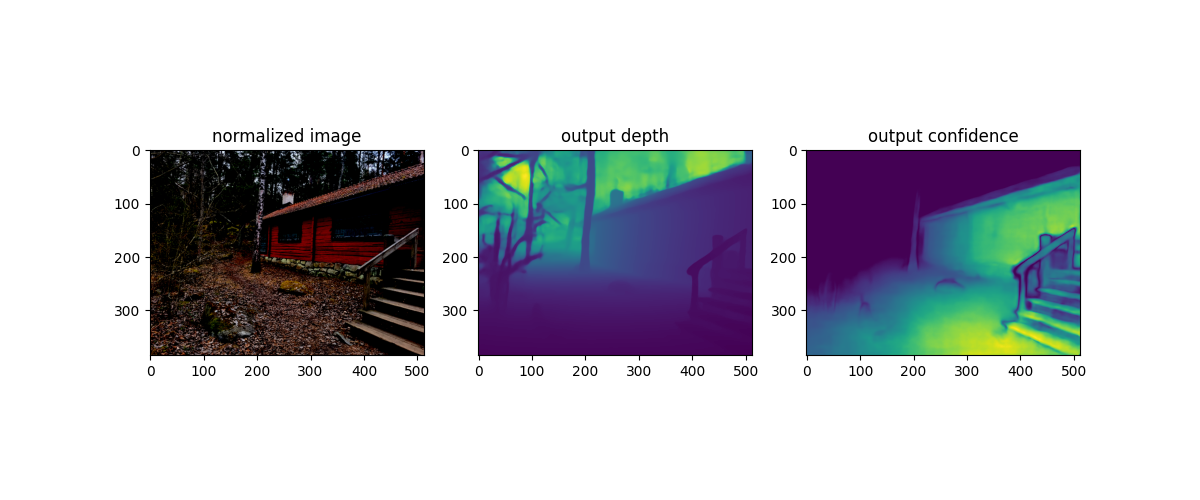

In [53]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

pair_idx = 0

ax[0].imshow(image_pairs[0][0]['img'].numpy()[0].transpose(1, 2, 0))
ax[0].set_title('normalized image')

ax[1].imshow(outputs['pred1']['pts3d'][pair_idx, ..., -1].numpy())
ax[1].set_title('output depth')

ax[2].imshow(outputs['pred1']['conf'][pair_idx].numpy())
ax[2].set_title('output confidence')

In [54]:
pair_idx = 0
for idx in [1, 2]:
    points = rotate_blender(outputs[f'pred{idx}']['pts3d' if idx == 1 else 'pts3d_in_other_view'].detach().cpu().numpy()[pair_idx].reshape(-1, 3))
    colors = dust3r.utils.image.rgb(outputs[f'view{idx}']['img'])[pair_idx].reshape(-1, 3)

    confidence = outputs[f'pred{idx}']['conf'].detach().cpu().numpy()[pair_idx].reshape(-1)

    idx1 = outputs['view1']['idx'][pair_idx]
    idx2 = outputs['view2']['idx'][pair_idx]

    bplt.Scatter(
        points[confidence > 1.5],
        color=colors[confidence > 1.5],
        marker_scale=0.001,
        marker_type='cubes',
        # subdivisions=0,
        name=f'image{idx1}_with_image{idx2}_view{idx}',
    )

Info: Deleted 11 object(s)



## Fused multi-view point maps

In [55]:
scene = dust3r.cloud_opt.global_aligner(
    dust3r_output=outputs,
    device="cuda",
    mode=dust3r.cloud_opt.GlobalAlignerMode.PointCloudOptimizer,
)
scene.compute_global_alignment(init='mst')

 init edge (0*,2*) score=87.96638488769531
 init edge (1*,0) score=42.224830627441406
 init loss = 0.012004668824374676
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals', 'im_conf.0', 'im_conf.1', 'im_conf.2']


100%|██████████| 300/300 [00:06<00:00, 45.01it/s, lr=0.01 loss=0.00714422]


0.007144216913729906

In [56]:
import plot_reconstruction
scene_points = scene.get_pts3d()
confidences = scene.get_conf()
poses = np.einsum('ij, ...jk->...ik', T_ydown2zup, scene.get_im_poses().detach().cpu())
intrinsics = scene.get_intrinsics().detach().cpu()

for i, points in enumerate(scene_points):
    confidence_mask = (confidences[i] > 1.5).reshape(-1).cpu()
    bplt.Scatter(
        rotate_blender(points.detach().cpu().numpy().reshape(-1 ,3))[confidence_mask],
        color=dust3r.utils.image.rgb(images[i]['img'][0]).reshape(-1, 3)[confidence_mask],
        marker_scale=0.0005,
        marker_type='cubes',
        name=f'points_{i}',
    )
    plot_reconstruction.plot_cameras(
        R=poses[i][:3, :3],
        t=poses[i][:3, -1],
        intrinsics=intrinsics[i],
        height=points.shape[0],
        width=points.shape[1],
        image_depth=0.01,
        with_fill=True,
        name=f'camera_{i}',
        thickness=0.0006
    )

# CroCo

In [57]:
from croco.models.croco import CroCoNet
ckpt = torch.load('/home/linus/workspace/croco/pretrained_models/CroCo_V2_ViTLarge_BaseDecoder.pth', 'cpu')
model = CroCoNet( **ckpt.get('croco_kwargs',{})).to("cuda")
model.eval()
model.load_state_dict(ckpt['model'], strict=True)

<All keys matched successfully>

In [58]:
from PIL import Image
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
device = "cuda"

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_mean_tensor = torch.tensor(imagenet_mean).view(1,3,1,1).to(device, non_blocking=True)
imagenet_std = [0.229, 0.224, 0.225]
imagenet_std_tensor = torch.tensor(imagenet_std).view(1,3,1,1).to(device, non_blocking=True)

trfs = Compose([ToTensor(), Normalize(mean=imagenet_mean, std=imagenet_std)])

image1 = Image.open('/home/linus/workspace/data/phone/house/images/20240331_180805.jpg').convert('RGB')
image2 = Image.open('/home/linus/workspace/data/phone/house/images/20240331_181200.jpg').convert('RGB')

image1 = image1.resize((int(image1.size[0] / image1.size[1] * 224), 224,))
image2 = image2.resize((int(image2.size[0] / image2.size[1] * 224), 224,))

image1 = trfs(image1).to(device, non_blocking=True).unsqueeze(0)[..., :224, :224]
image2 = trfs(image2).to(device, non_blocking=True).unsqueeze(0)[..., :224, :224]

In [59]:
with torch.inference_mode():
    out, mask, target = model(image1, image2)

In [60]:
patchified = model.patchify(image1)
mean = patchified.mean(dim=-1, keepdim=True)
var = patchified.var(dim=-1, keepdim=True)
decoded_image = model.unpatchify(out * (var + 1.e-6)**.5 + mean)
# undo imagenet normalization, prepare masked image
decoded_image = decoded_image * imagenet_std_tensor + imagenet_mean_tensor
input_image = image1 * imagenet_std_tensor + imagenet_mean_tensor
ref_image = image2 * imagenet_std_tensor + imagenet_mean_tensor
# image_masks = model.unpatchify(model.patchify(torch.ones_like(ref_image)) * mask[:,:,None])
image_masks = model.unpatchify(model.patchify(torch.ones_like(ref_image)) * mask[:,:,None])
masked_input_image = ((1 - image_masks) * input_image)

decoded_image_v2 = model.unpatchify(model.patchify(decoded_image) * mask[..., None] + model.patchify(input_image) * (1 - mask[..., None]*1.))

# make visualization
visualization = torch.cat((ref_image, masked_input_image, decoded_image, input_image), dim=3) # 4*(B, 3, H, W) -> B, 3, H, W*4
B, C, H, W = visualization.shape
visualization = visualization.permute(1, 0, 2, 3).reshape(C, B*H, W)
visualization = torchvision.transforms.functional.to_pil_image(torch.clamp(visualization, 0, 1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'decoded_image_v2')

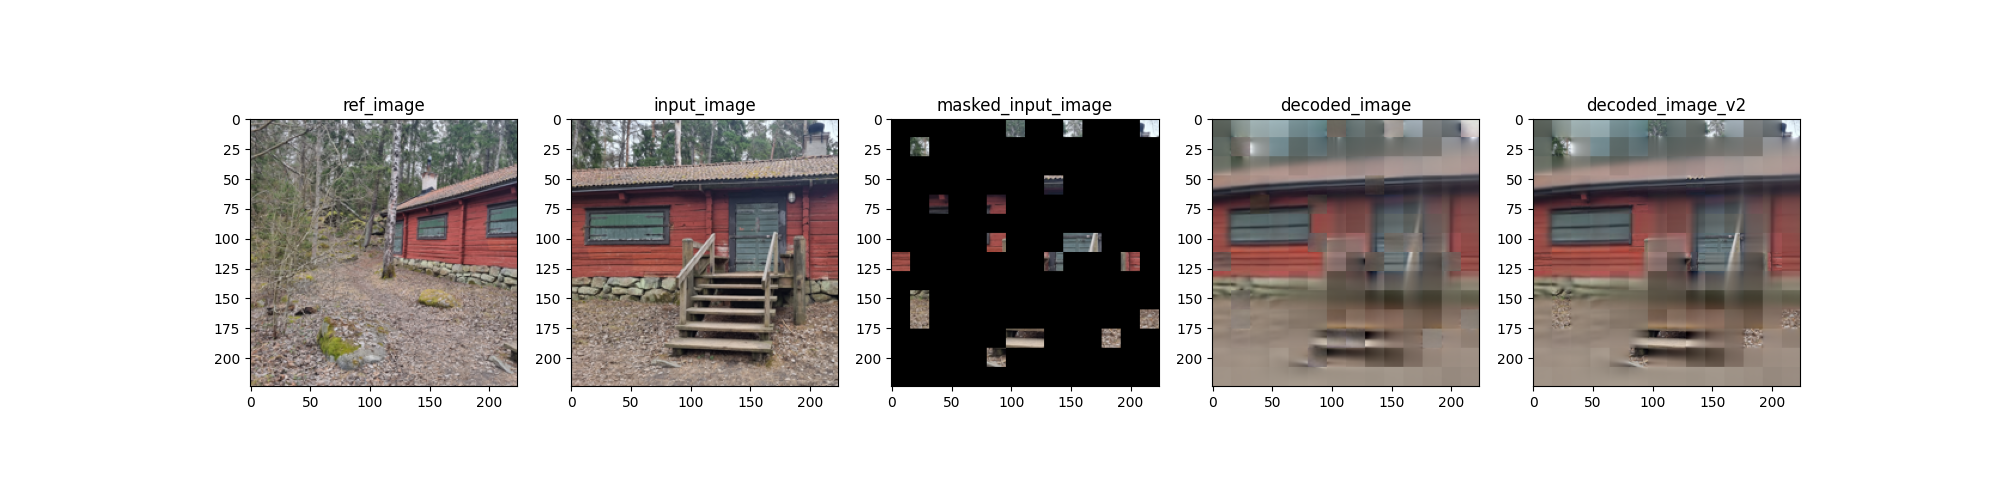

In [61]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(1, len(ax)-1):
    ax[i].sharex(ax[i+1])
    ax[i].sharey(ax[i+1])

ax[0].imshow(ref_image.detach().cpu().numpy()[0].transpose(1, 2, 0))
ax[0].set_title('ref_image')

ax[1].imshow(input_image.detach().cpu().numpy()[0].transpose(1, 2, 0))
ax[1].set_title('input_image')

ax[2].imshow(masked_input_image.detach().cpu().numpy()[0].transpose(1, 2, 0))
ax[2].set_title('masked_input_image')

ax[3].imshow(decoded_image.detach().cpu().numpy()[0].transpose(1, 2, 0))
ax[3].set_title('decoded_image')

ax[4].imshow(decoded_image_v2.detach().cpu().numpy()[0].transpose(1, 2, 0))
ax[4].set_title('decoded_image_v2')
